In [25]:
import networkx as nx
import pandas as pd
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import correlation

In [26]:
abyss_data = pd.read_csv('data/abyss_rank_activity.csv')
abyss_data.head()

,Version,Version Name,Total Samples,Effective Samples,Patch,Patch Label
0,51,Version: 6.0(Phase II),123768,97455,6.0,6.0 II
1,50,Version: 6.0(Phase I),101909,77793,6.0,6.0 I
2,49,Version: 5.8(Phase I),142018,120354,5.8,5.8 I
3,48,Version: 5.7(Phase I),122176,94710,5.7,5.7 I
4,47,Version: 5.6(Phase II),101501,82521,5.6,5.6 II


In [27]:
base_dir = 'graphs'

# Extract phase numbers and sort numerically
def extract_phase(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(1)) if match else float('inf')

# Get and sort files graph_1.pickle → graph_51.pickle
graph_files = sorted([f for f in os.listdir(base_dir) if f.startswith("graph_") and f.endswith(".pickle")],
                     key=extract_phase)

# Initialize centrality matrices as dictionaries (phase: {character: score})
degree_matrix = {}
betweenness_matrix = {}
eigenvector_matrix = {}

all_characters = set()

# Load each graph and compute centralities
for file in graph_files[1:]:
    phase = extract_phase(file)  # numeric phase number
    filepath = os.path.join(base_dir, file)
    
    with open(filepath, 'rb') as f:
        G = pickle.load(f)

    # Ensure graph is undirected
    if not isinstance(G, nx.Graph):
        G = nx.Graph(G)

    # Collect all characters in this graph
    nodes = list(G.nodes())
    all_characters.update(nodes)
    
    # Compute centralities
    # Using weights if available
    degree_cent = nx.degree_centrality(G)  # networkx uses normalized degree centrality

    # Betweenness
    for u, v, data in G.edges(data=True):
        if 'weight' in data and data['weight'] != 0:
            data['distance'] = 1.0 / data['weight']
        else:
            data['distance'] = float('inf')
    betweenness_cent = nx.betweenness_centrality(G, weight='distance', normalized=True)

    try:
        eigenvector_cent = nx.eigenvector_centrality(G, weight='weight', max_iter=500)
    except nx.PowerIterationFailedConvergence:
        print(f"  Eigenvector centrality did not converge for Phase {phase}. Filling with NaN.")
        eigenvector_cent = {node: np.nan for node in nodes}

    # Store values in phase dictionaries
    degree_matrix[phase] = degree_cent
    betweenness_matrix[phase] = betweenness_cent
    eigenvector_matrix[phase] = eigenvector_cent

# Convert to DataFrames
all_characters = sorted(all_characters)  # consistent row ordering
phases = sorted(degree_matrix.keys())  # sorted phase ordering

def build_matrix(matrix_dict, name):
    df = pd.DataFrame(index=all_characters, columns=phases, dtype=float)
    for phase in phases:
        for char in all_characters:
            df.at[char, phase] = matrix_dict.get(phase, {}).get(char, np.nan)
    df.to_csv(f"data/{name}_centrality_matrix.csv")
    return df

degree_df = build_matrix(degree_matrix, "degree")
betweenness_df = build_matrix(betweenness_matrix, "betweenness")
eigenvector_df = build_matrix(eigenvector_matrix, "eigenvector")


In [28]:
def raw_cos(a, b):
    # Only consider indices where both a and b are non-null
    common_idx = a.notna() & b.notna()
    
    # Return 0 if no common ratings
    if common_idx.sum() == 0:
        return 0
    
    # Extract the common ratings
    v1 = a[common_idx].values
    v2 = b[common_idx].values
    
    
    # Compute cosine similarity
    numerator = np.dot(v1, v2)
    denom = np.linalg.norm(v1) * np.linalg.norm(v2)
    
    if denom == 0:
        return 0
    
    return numerator / denom

In [29]:
def raw_correl(a, b):
    # Only consider indices where both a and b are non-null
    common_idx = a.notna() & b.notna()
    
    # Return 0 if no common ratings
    if common_idx.sum() == 0:
        return 0
    
    # Extract the common ratings
    v1 = a[common_idx].values
    v2 = b[common_idx].values
    
    return correlation(v1, v2)

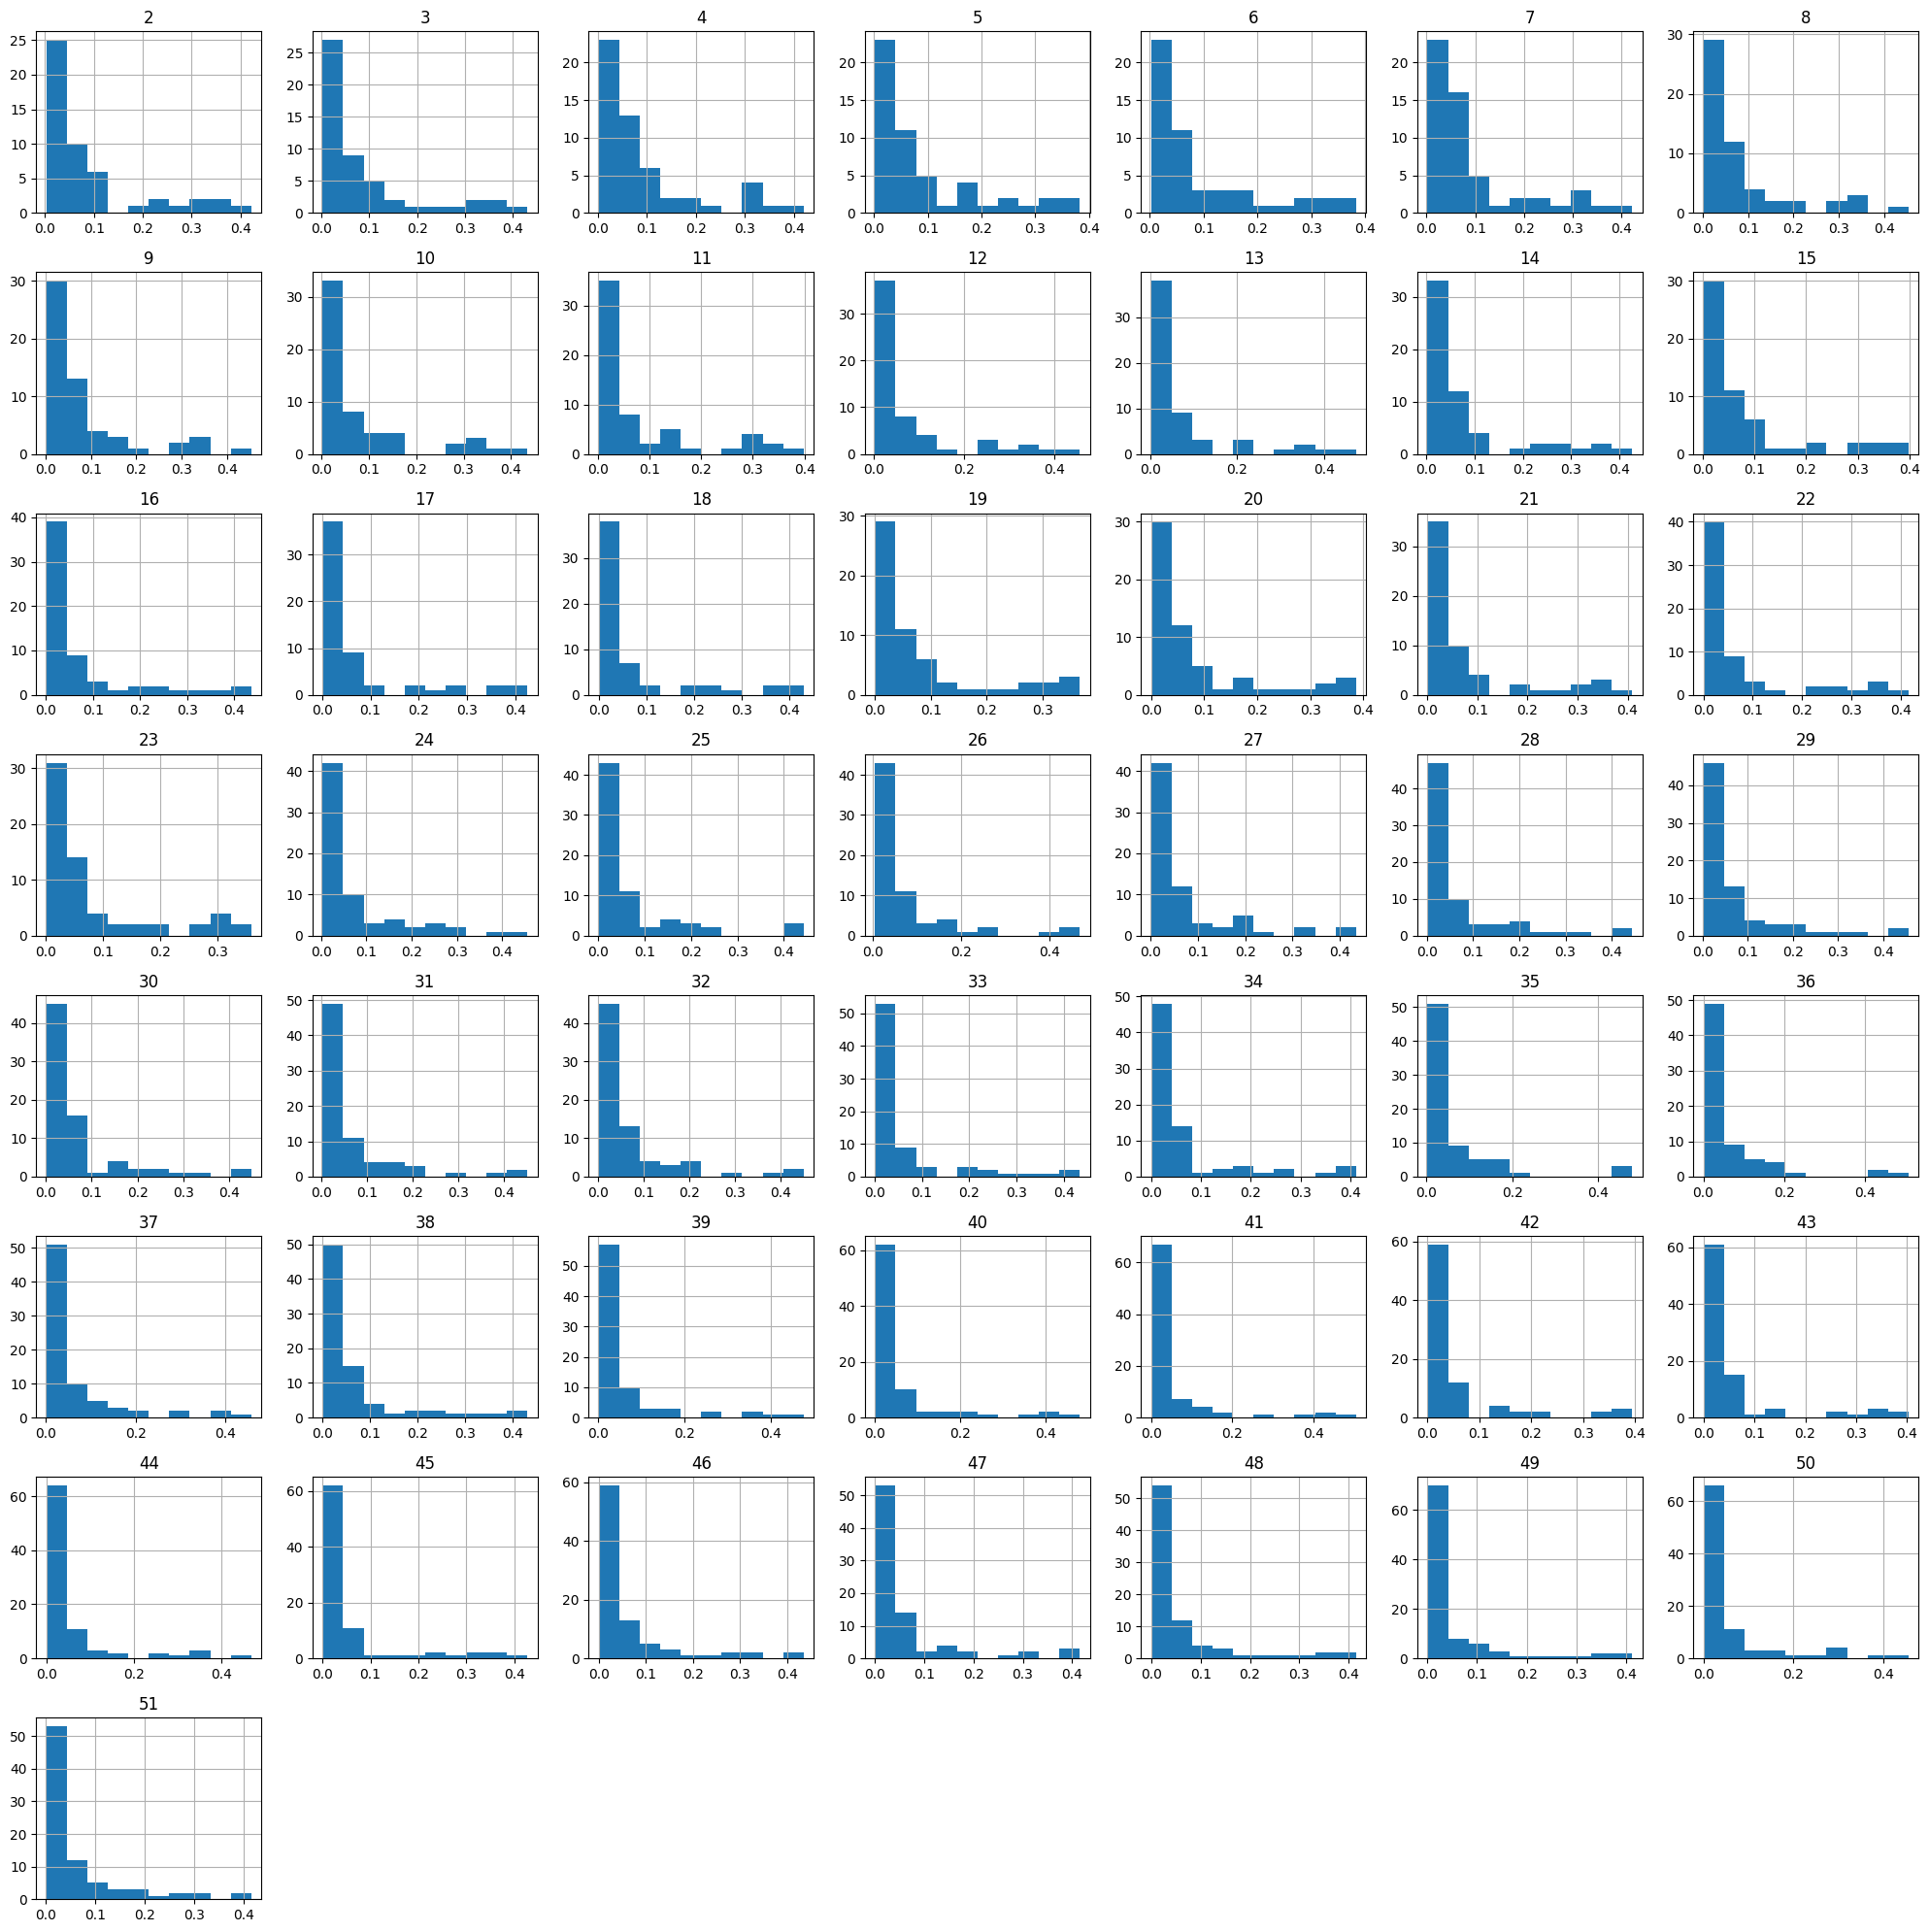

In [44]:
eigenvector_df.hist(figsize=(20, 20))
plt.tight_layout()

In [49]:
eig_meta_changes = []
for version in eigenvector_df.columns[:-1]:
    prev_version = eigenvector_df[version]
    curr_version = eigenvector_df[version + 1]
    # Keep only characters with prev eigenvector > 0.1
    mask = prev_version > 0.1
    prev_filtered = prev_version[mask]
    curr_filtered = curr_version[mask]  # align to same characters
    
    # Compute correlation distance (or similarity)
    eig_meta_changes.append(raw_correl(prev_filtered, curr_filtered))


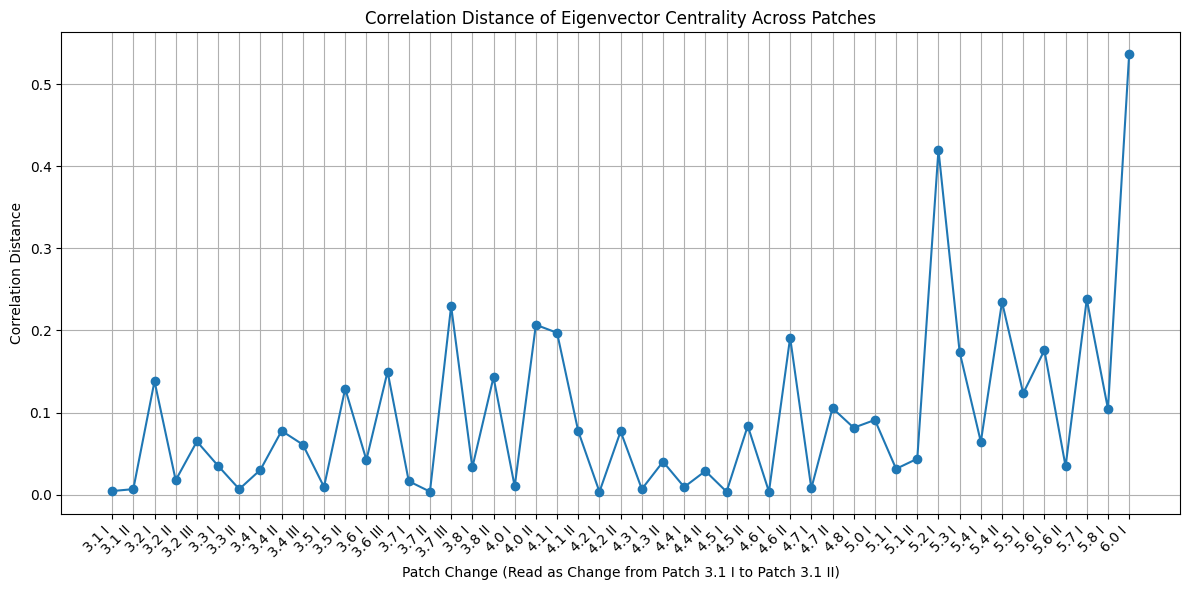

In [50]:
# Then because we are taking the change, we need a differenced
differenced_df = abyss_data.iloc[1:50].iloc[::-1]

plt.figure(figsize=(12, 6))
plt.plot(differenced_df['Version'], eig_meta_changes, marker='o')

plt.title('Correlation Distance of Eigenvector Centrality Across Patches')
plt.xlabel('Patch Change (Read as Change from Patch 3.1 I to Patch 3.1 II)')
plt.ylabel('Correlation Distance')
plt.grid(True)

# Apply Patch_Labeled as tick labels
plt.xticks(ticks=differenced_df['Version'], labels=differenced_df['Patch Label'], rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [52]:
betweenness_df.describe()

,2,3,4,5,6,7,8,9,10,11,...,42,43,44,45,46,47,48,49,50,51
count,50.000000,51.000000,53.000000,52.000000,51.000000,55.000000,55.000000,57.000000,56.000000,59.000000,...,84.000000,88.000000,87.000000,84.000000,88.000000,81.000000,81.000000,95.000000,91.000000,83.000000
mean,0.029864,0.030796,0.029141,0.031478,0.029916,0.029973,0.030837,0.032035,0.027573,0.026680,...,0.021641,0.022518,0.020690,0.024565,0.021862,0.026703,0.026969,0.019853,0.024862,0.021415
std,0.106831,0.101392,0.091061,0.097529,0.094879,0.086166,0.081856,0.084722,0.082064,0.081195,...,0.072375,0.077230,0.093341,0.092655,0.094904,0.099513,0.098821,0.095827,0.104070,0.098361
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000294,0.000067,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.639456,0.604082,0.527903,0.543529,0.517551,0.415094,0.387142,0.297403,0.447811,0.446461,...,0.425801,0.561615,0.717921,0.628857,0.628442,0.704114,0.589557,0.819378,0.814232,0.850045


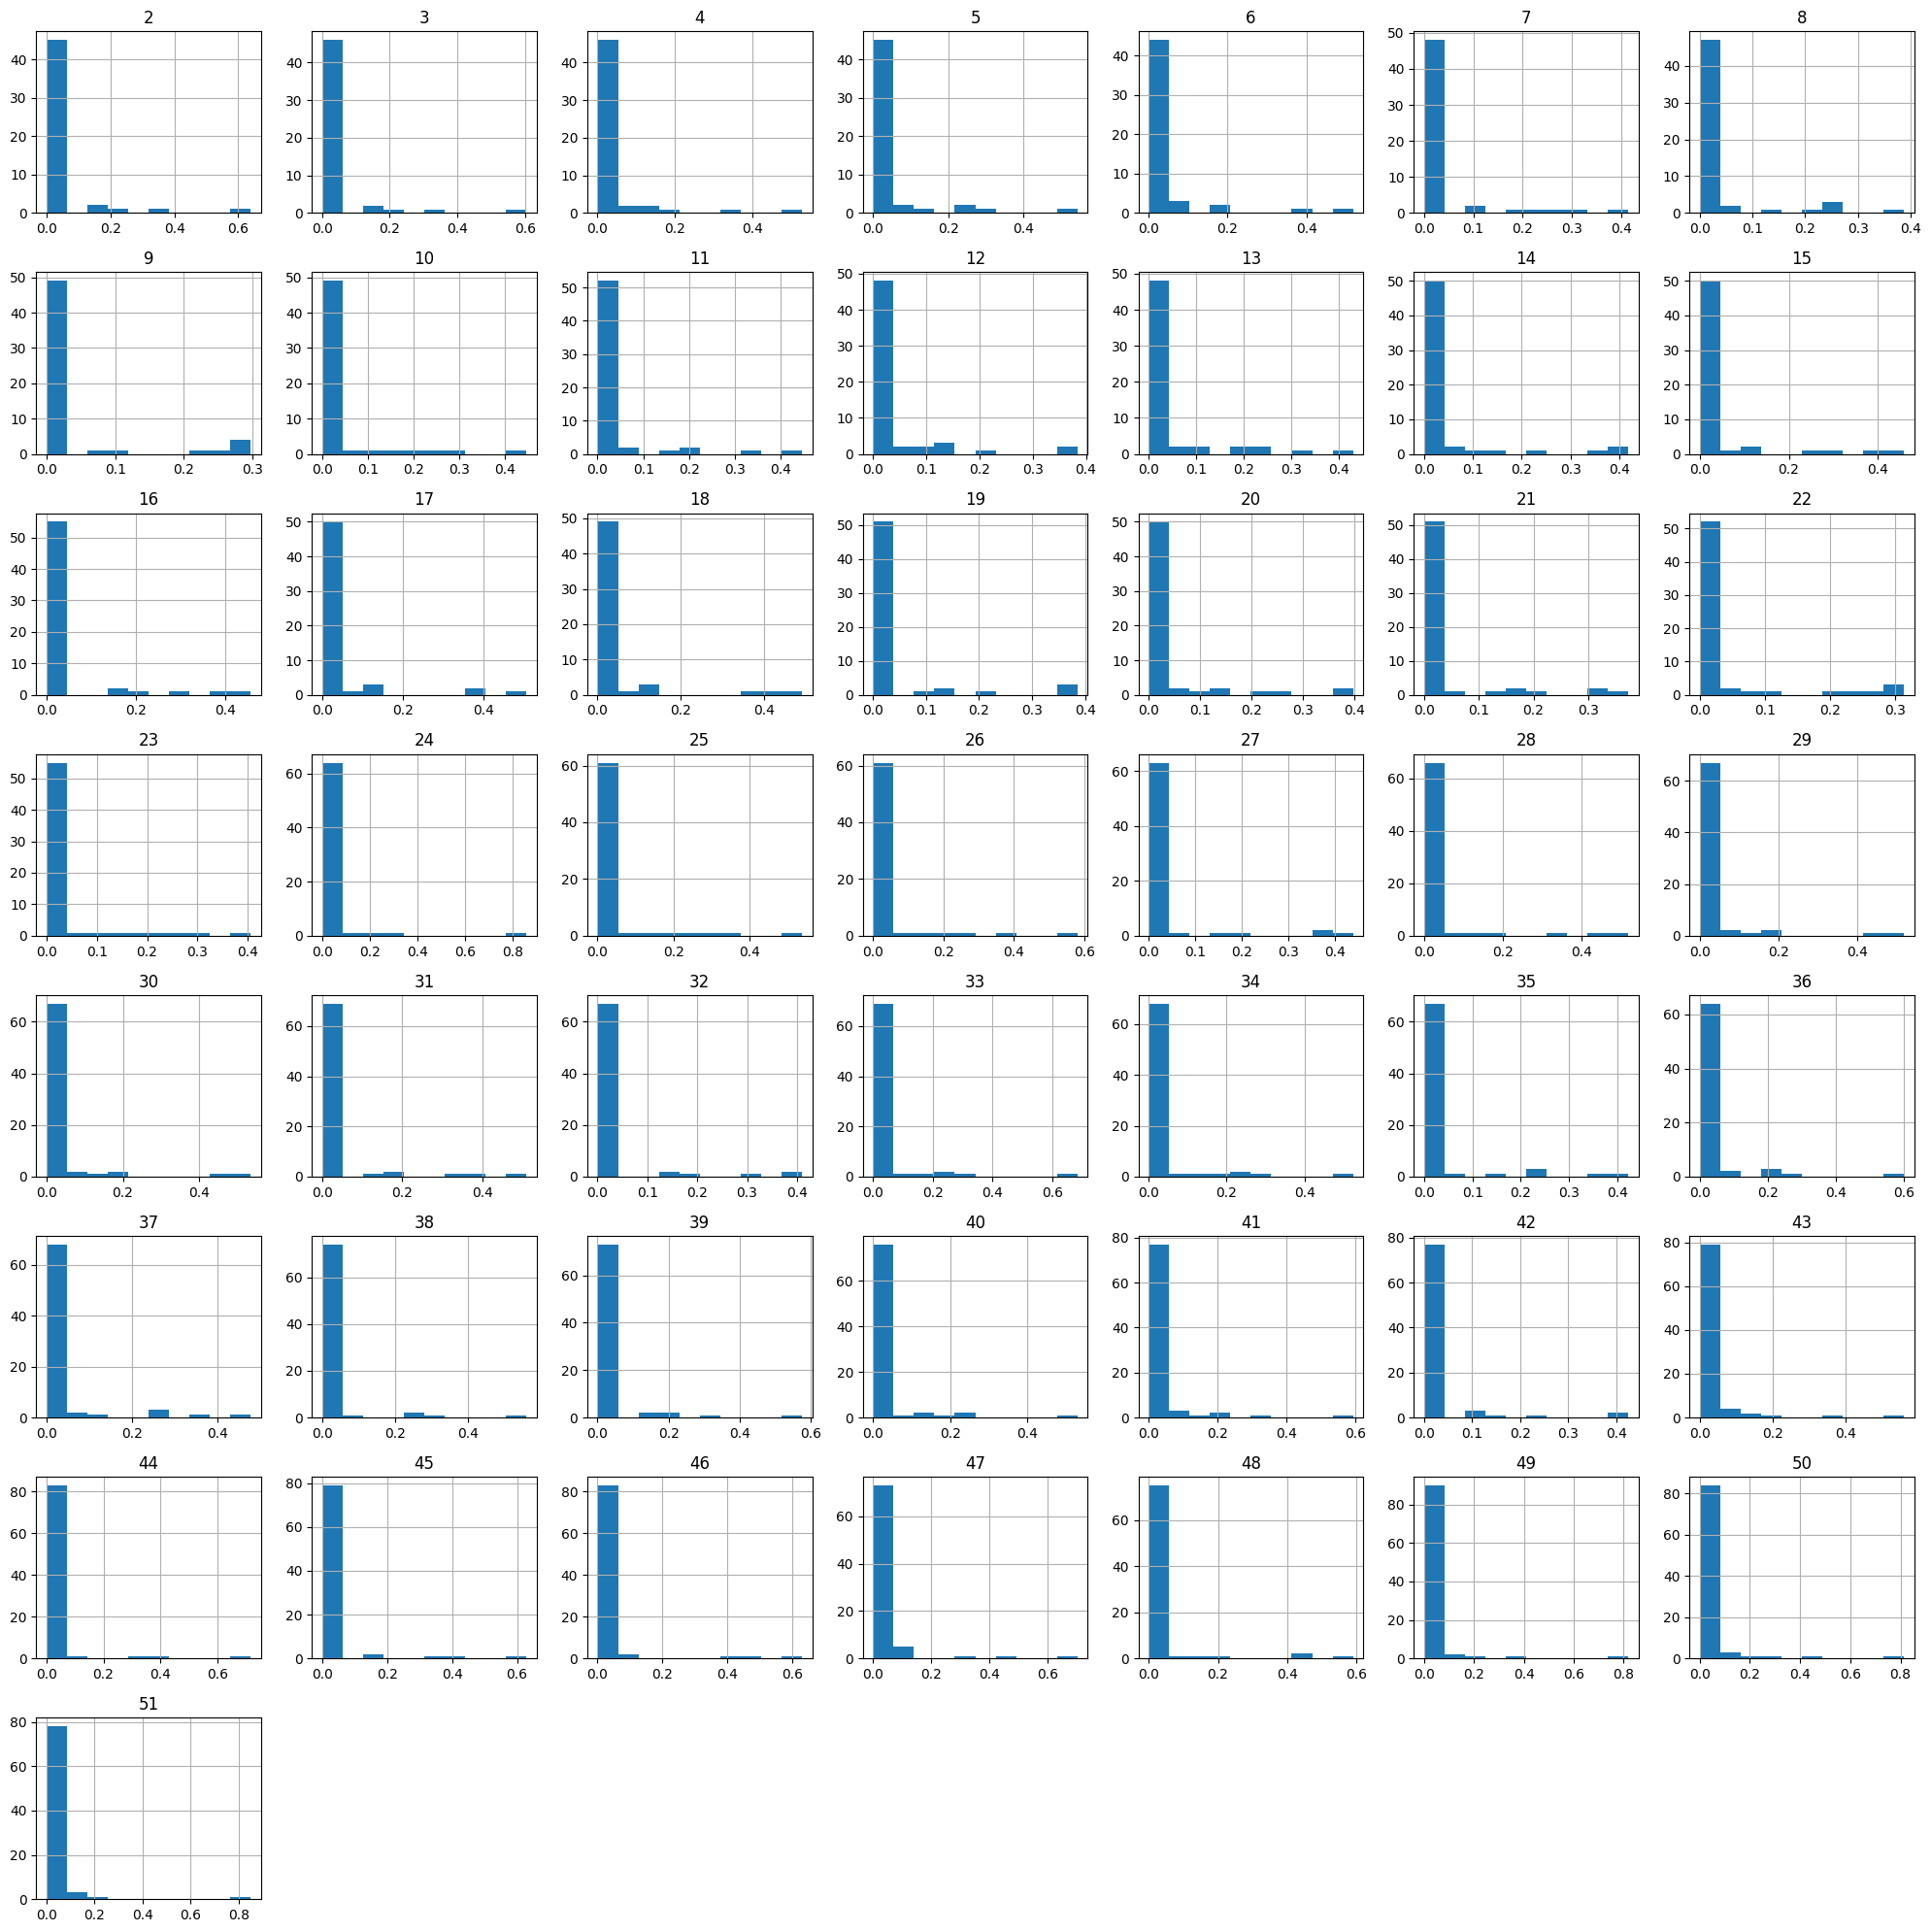

In [51]:
betweenness_df.hist(figsize=(20, 20))
plt.tight_layout()

In [54]:
betwenness_meta_changes = []
for version in betweenness_df.columns[:-1]:
    prev_version = betweenness_df[version]
    curr_version = betweenness_df[version + 1]
    # Keep only characters with prev betweenness > 0.1
    mask = prev_version > 0.1
    prev_filtered = prev_version[mask]
    curr_filtered = curr_version[mask]  # align to same characters
    
    # Compute correlation distance or similarity
    betwenness_meta_changes.append(raw_correl(prev_filtered, curr_filtered))


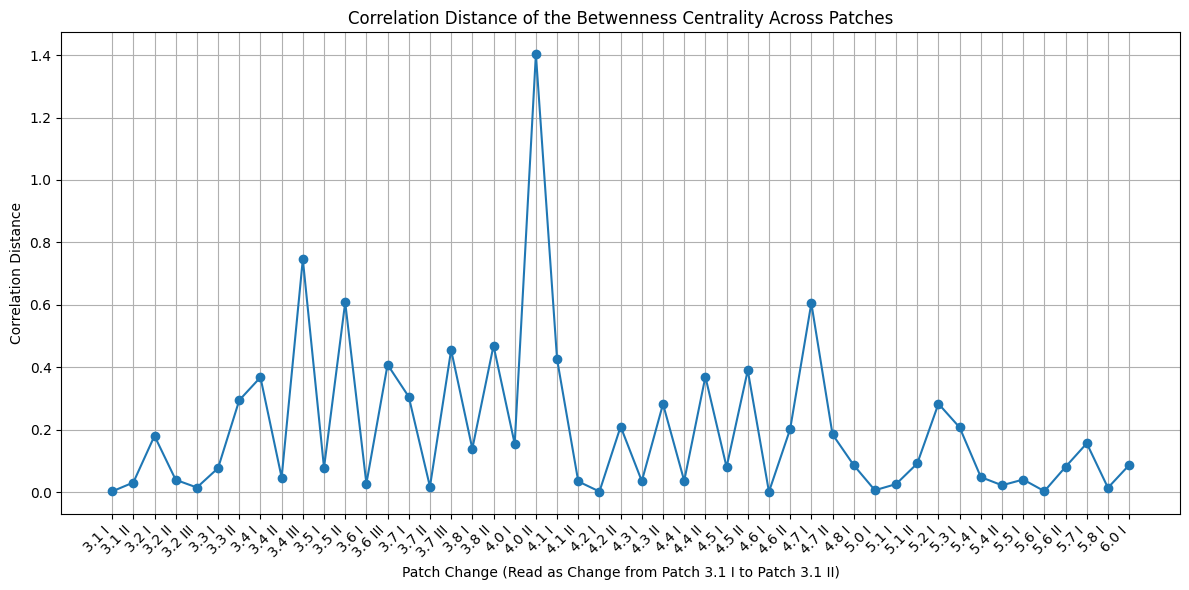

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(differenced_df['Version'], betwenness_meta_changes, marker='o')

plt.title('Correlation Distance of the Betwenness Centrality Across Patches')
plt.xlabel('Patch Change (Read as Change from Patch 3.1 I to Patch 3.1 II)')
plt.ylabel('Correlation Distance')
plt.grid(True)

# Apply Patch_Labeled as tick labels
plt.xticks(ticks=differenced_df['Version'], labels=differenced_df['Patch Label'], rotation=45, ha='right')

plt.tight_layout()
plt.show()


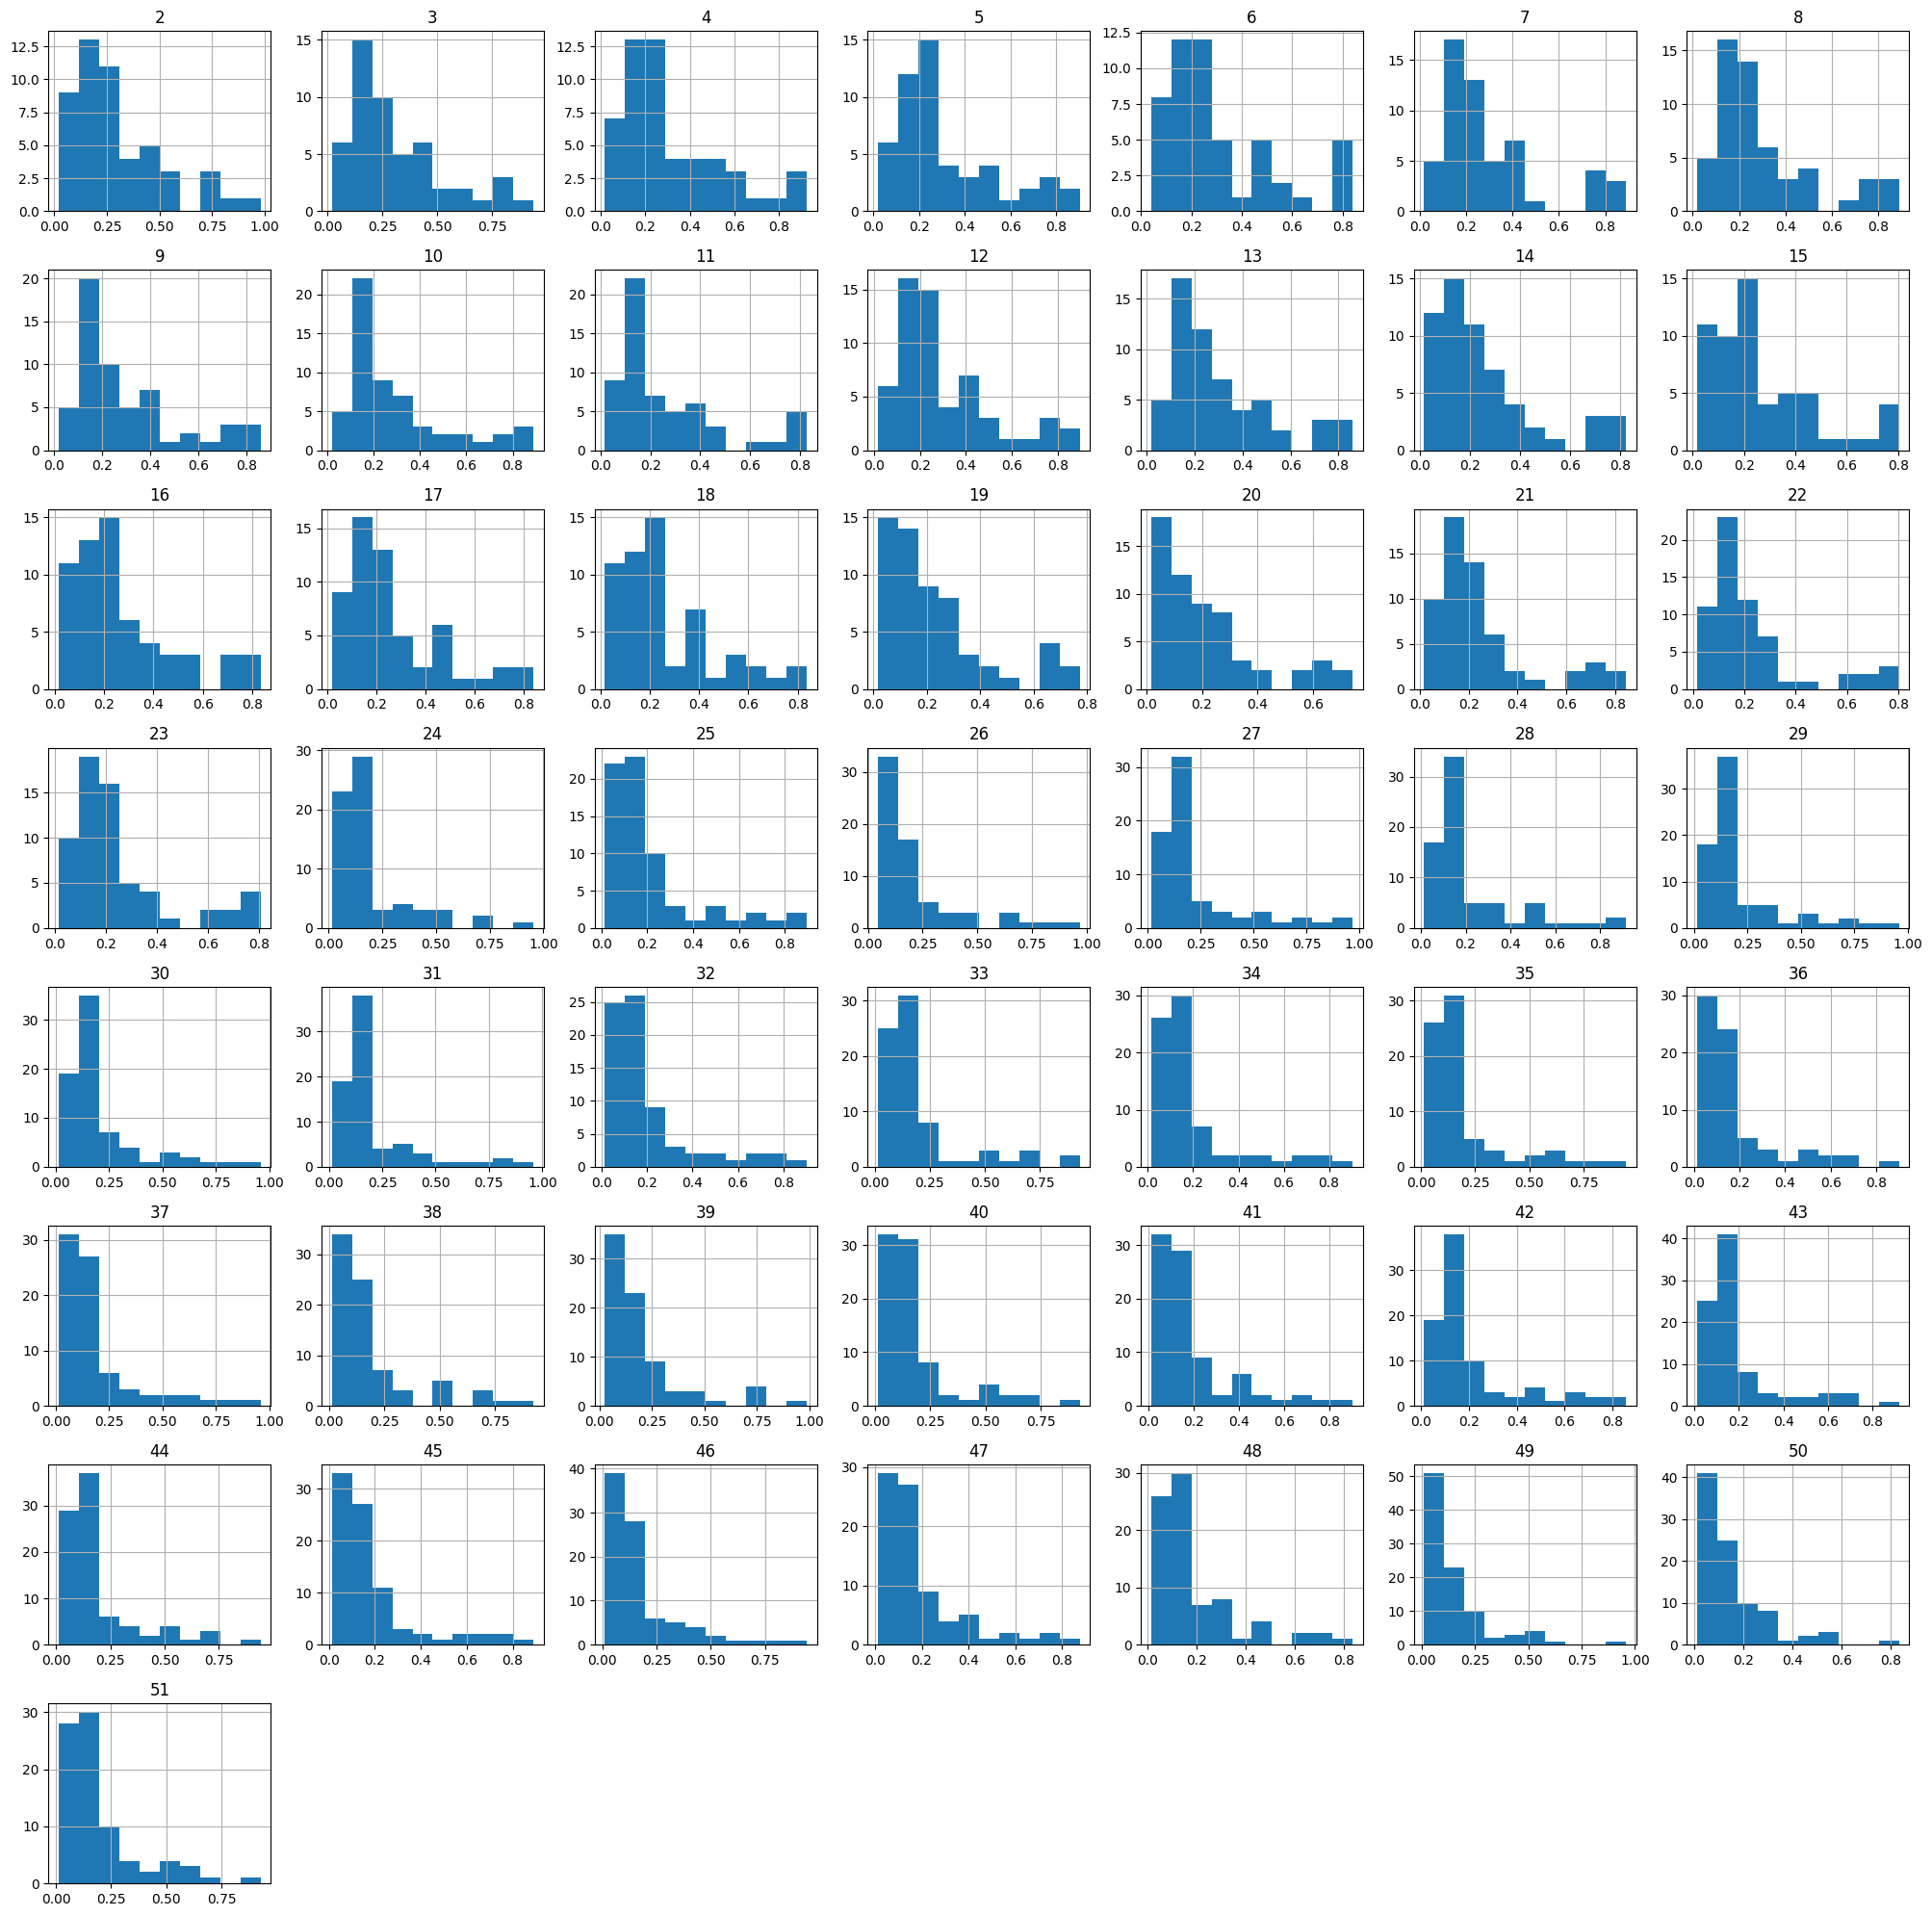

In [56]:
degree_df.hist(figsize=(20, 20))
plt.tight_layout()

In [61]:
degree_df.describe()

,2,3,4,5,6,7,8,9,10,11,...,42,43,44,45,46,47,48,49,50,51
count,50.000000,51.000000,53.000000,52.000000,51.000000,55.000000,55.000000,57.000000,56.000000,59.000000,...,84.000000,88.000000,87.000000,84.000000,88.000000,81.000000,81.000000,95.000000,91.000000,83.000000
mean,0.296327,0.307451,0.312772,0.309955,0.298824,0.300337,0.302357,0.296992,0.285065,0.262420,...,0.201951,0.183386,0.179631,0.187034,0.177116,0.183333,0.185185,0.147816,0.144078,0.184837
std,0.227825,0.218905,0.226481,0.223498,0.223156,0.224205,0.221106,0.216049,0.221656,0.216462,...,0.196799,0.183080,0.186044,0.186373,0.179314,0.182153,0.174845,0.162249,0.147976,0.174914
min,0.020408,0.020000,0.019231,0.019608,0.040000,0.018519,0.018519,0.017857,0.018182,0.017241,...,0.012048,0.011494,0.011628,0.012048,0.011494,0.012500,0.012500,0.010638,0.011111,0.012195
25%,0.142857,0.160000,0.153846,0.156863,0.150000,0.166667,0.157407,0.160714,0.127273,0.129310,...,0.096386,0.089080,0.075581,0.072289,0.077586,0.062500,0.062500,0.042553,0.033333,0.073171
50%,0.224490,0.260000,0.230769,0.235294,0.260000,0.222222,0.240741,0.214286,0.200000,0.172414,...,0.126506,0.120690,0.116279,0.132530,0.120690,0.125000,0.125000,0.095745,0.100000,0.134146
75%,0.403061,0.420000,0.423077,0.382353,0.400000,0.370370,0.361111,0.392857,0.363636,0.344828,...,0.207831,0.186782,0.186047,0.204819,0.186782,0.225000,0.237500,0.170213,0.188889,0.231707
max,0.979592,0.940000,0.923077,0.901961,0.840000,0.888889,0.888889,0.857143,0.890909,0.827586,...,0.855422,0.919540,0.941860,0.891566,0.942529,0.875000,0.837500,0.957447,0.833333,0.926829


In [62]:
degree_meta_changes = []
for version in degree_df.columns[:-1]:
    prev_version = degree_df[version]
    curr_version = degree_df[version + 1]
    # Keep only characters with prev degree > 0.2
    mask = prev_version > 0.2
    prev_filtered = prev_version[mask]
    curr_filtered = curr_version[mask]  # align to same characters
    
    # Compute correlation distance or similarity
    degree_meta_changes.append(raw_correl(prev_filtered, curr_filtered))


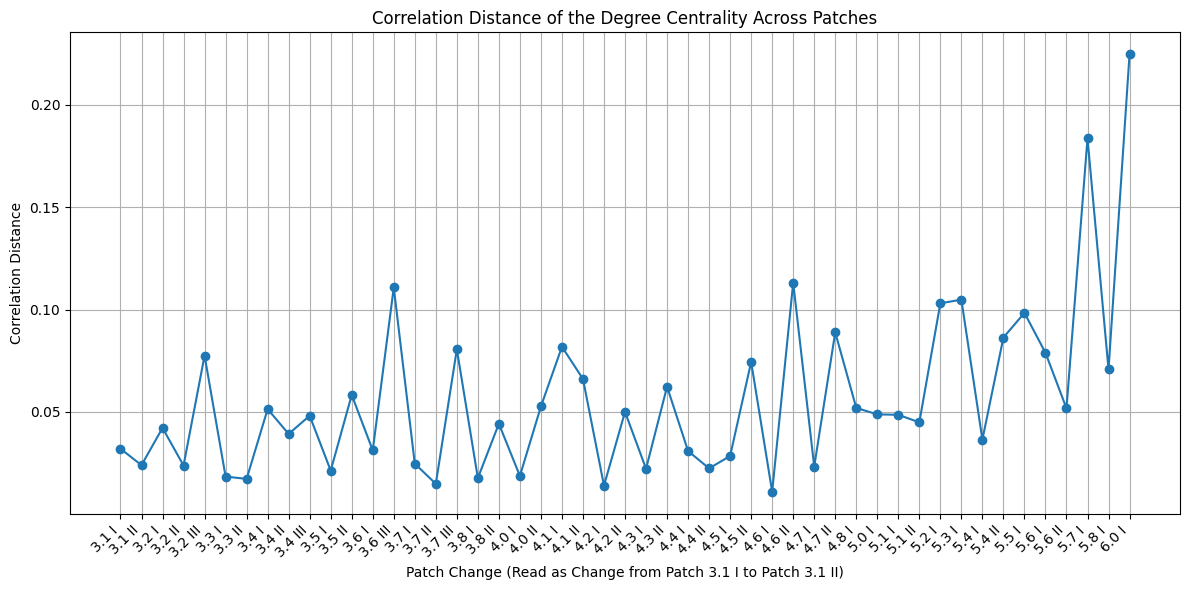

In [64]:
plt.figure(figsize=(12, 6))
plt.plot(differenced_df['Version'], degree_meta_changes, marker='o')

plt.title('Correlation Distance of the Degree Centrality Across Patches')
plt.xlabel('Patch Change (Read as Change from Patch 3.1 I to Patch 3.1 II)')
plt.ylabel('Correlation Distance')
plt.grid(True)

# Apply Patch_Labeled as tick labels
plt.xticks(ticks=differenced_df['Version'], labels=differenced_df['Patch Label'], rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [ ]:
meta_changes_df = pd.DataFrame({
    'Patch': differenced_df['Patch Label'].values,
    'Eigenvector Change': eig_meta_changes,
    'Betweenness Change': betwenness_meta_changes,
    'Degree Change': degree_meta_changes
})
changes = ['Eigenvector Change', 'Betweenness Change', 'Degree Change']

target = pd.read_csv('data/abyss_rank_activity.csv').iloc[1:50][::-1]['Effective Samples']

(49, 4)

In [113]:
X = meta_changes_df[changes].reset_index(drop=True)
y = target.reset_index(drop=True)

corr_matrix = X.join(y.rename('Engagement')).corr()
corr_matrix



,Eigenvector Change,Betweenness Change,Degree Change,Engagement
Eigenvector Change,1.000000,0.203439,0.846095,-0.173555
Betweenness Change,0.203439,1.000000,0.048842,-0.008970
Degree Change,0.846095,0.048842,1.000000,-0.176358
Engagement,-0.173555,-0.008970,-0.176358,1.000000


In [111]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R²:", r2_score(y, y_pred))
print("MSE:", mean_squared_error(y, y_pred))


Coefficients: [-55903.14351382   3611.90549359]
Intercept: 103216.04993666345
R²: 0.03084502844723014
MSE: 1070445117.4222629
